計算無線電地圖...


[1, 2]
RSS形狀: (835, 1189)
期望信號RSS: (835, 1189)
干擾信號RSS: (835, 1189)
計算傳播路徑...


/tmp/ipykernel_49582/2771128703.py:143: RuntimeWarning: divide by zero encountered in divide
  sinr = rss_des / (rss_jam )
/tmp/ipykernel_49582/2771128703.py:143: RuntimeWarning: invalid value encountered in divide
  sinr = rss_des / (rss_jam )
/tmp/ipykernel_49582/2771128703.py:208: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


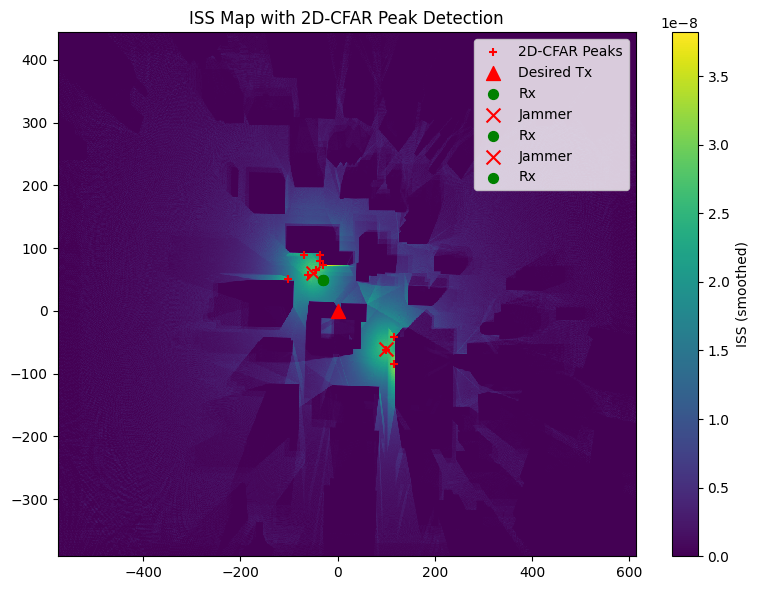

Detected peak coordinates (row, col):
[[463 545]
 [306 691]
 [479 539]
 [470 539]
 [349 691]
 [455 530]
 [448 514]
 [329 674]
 [441 474]
 [480 507]]


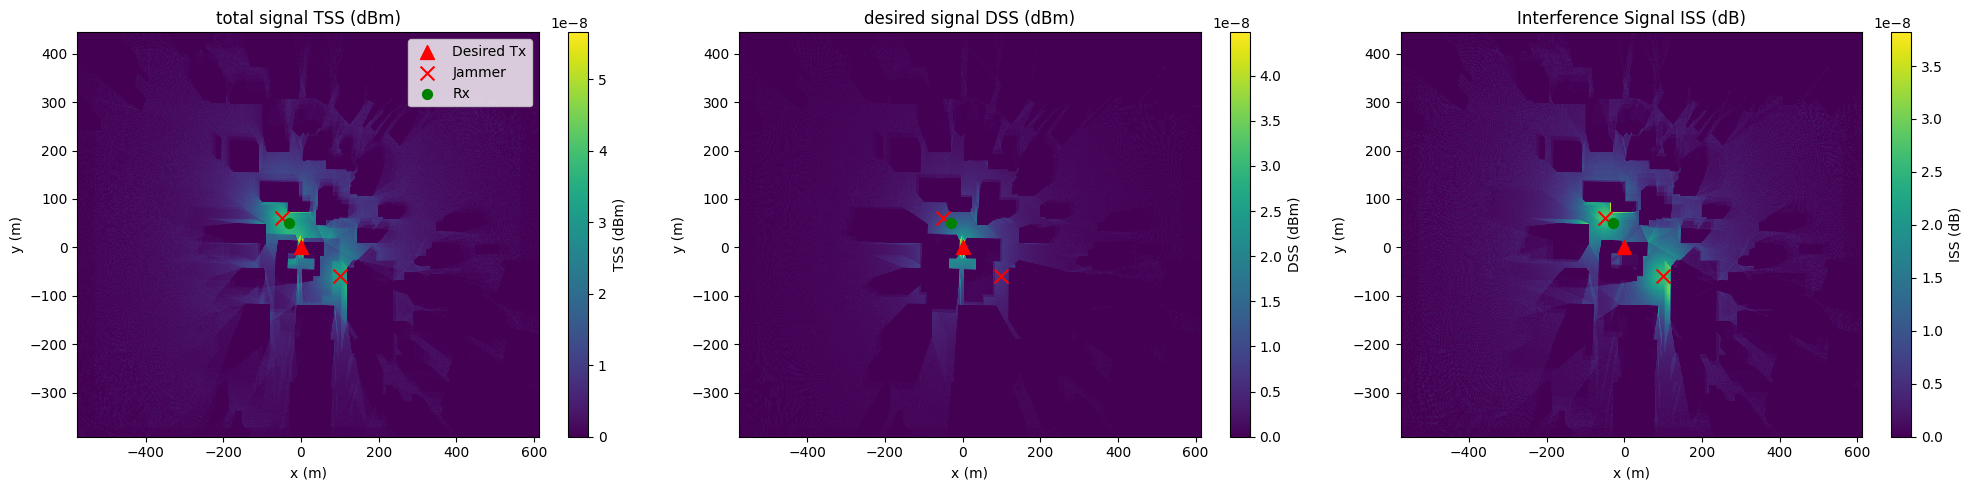

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMapSolver, PathSolver
import sionna
from scipy.ndimage import maximum_filter
from scipy import ndimage
# Fixed import - use the correct function name

from skimage.feature import peak_local_max


from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.cluster import DBSCAN



# GPU設置
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# 參數設置
# 場景參數
SCENE_SIZE = 128  # 場景大小 128m x 128m
ALTITUDE = 30    # UAV飛行高度 60m
RESOLUTION = 4    # 解析度 4m

# 天線配置
TX_ARRAY_CONFIG = {
    "num_rows": 1,
    "num_cols": 1,
    "vertical_spacing": 0.5,
    "horizontal_spacing": 0.5,
    "pattern": "iso",
    "polarization": "V"
}
RX_ARRAY_CONFIG = TX_ARRAY_CONFIG

# 發射器配置（3個期望發射器，3個干擾器）
TX_LIST = [
    # 期望發射器 (desired)
    {"name": "tx0", "position": [0, 0, 60], "orientation": [np.pi*5/6, 0, 0], "role": "desired", "power_dbm": 30},

    # 干擾器 (jammer)
    {"name": "jam1", "position": [-50, 60, 60], "orientation": [np.pi*5/6, 0, 0], "role": "jammer", "power_dbm": 30},
    {"name": "jam2", "position": [100, -60, 60], "orientation": [np.pi*5/6, 0, 0], "role": "jammer", "power_dbm": 30},
    
    
]

# 接收器配置
RX_POSITION = [-30, 50, 20]

# RadioMapSolver參數
RMSOLVER_ARGS = {
    "max_depth": 10,
    "cell_size": (1., 1.),
    "samples_per_tx": 10**7,
    "refraction": False,
    "los": True,
    "specular_reflection": True
}



"""創建單筆資料樣本"""

# 1. 載入或創建場景
try:
    # 嘗試載入自定義場景
    scene = load_scene("GIS.xml")
except:
    # 如果沒有自定義場景，使用內建場景
    print("使用內建場景...")
    scene = load_scene(sionna.rt.scene.etoile)

# 2. 設置天線陣列
scene.tx_array = PlanarArray(**TX_ARRAY_CONFIG)
scene.rx_array = PlanarArray(**RX_ARRAY_CONFIG)

# 3. 清除現有的發射器和接收器
for tx_name in list(scene.transmitters):
    scene.remove(tx_name)
for rx_name in list(scene.receivers):
    scene.remove(rx_name)

# 4. 添加發射器
transmitters = []
for tx_info in TX_LIST:
    tx = Transmitter(
        name=tx_info["name"],
        position=tx_info["position"],
        orientation=tx_info["orientation"],
        power_dbm=tx_info["power_dbm"]
    )
    # 設置角色屬性（用於後續識別）
    tx.role = tx_info["role"]
    scene.add(tx)
    transmitters.append(tx)

# 5. 添加接收器
rx = Receiver(name="rx", position=RX_POSITION)
scene.add(rx)

# 6. 計算無線電地圖
print("計算無線電地圖...")
rm_solver = RadioMapSolver()
rm = rm_solver(scene=scene, **RMSOLVER_ARGS)


# 7. 提取資料
# 獲取cell中心座標
cc = rm.cell_centers.numpy()
x_unique = cc[0, :, 0]
y_unique = cc[:, 0, 1]

# 獲取所有發射器
all_txs = [scene.get(name) for name in scene.transmitters]

# 分組：期望發射器和干擾器
idx_des = [i for i, tx in enumerate(all_txs) if tx.role == 'desired']
idx_jam = [i for i, tx in enumerate(all_txs) if tx.role == 'jammer']
print(idx_jam)

# 獲取RSS（接收信號強度）
rss_list = [rm.rss[i].numpy() for i in range(len(all_txs))]
WSS = rm.rss[:].numpy()
TSS = np.sum(WSS,axis=0)  # 將所有發射器的RSS加總
print("RSS形狀:", TSS.shape)
DSS = np.sum(WSS[idx_des,:,:],axis=0)
ISS = np.sum(WSS[idx_jam,:,:],axis=0)

# 計算期望信號總功率和干擾信號總功率
rss_des = sum(rss_list[i] for i in idx_des)
print("期望信號RSS:", rss_des.shape)
rss_jam = np.sum(WSS[idx_jam,:,:],axis=0)
print("干擾信號RSS:", rss_jam.shape)

# 計算SINR（信號與干擾加噪聲比）
sinr = rss_des / (rss_jam )
sinr_db = 10 * np.log10(np.clip(sinr, 1e-12, None))

# 8. 計算路徑（可選）
print("計算傳播路徑...")
path_solver = PathSolver()
paths = path_solver(
    scene=scene,
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=False,
    synthetic_array=True,
    seed=42
)

# 9. 使用改進的2D CFAR檢測干擾源位置
iss_dbm = 10 * np.log10(np.clip(ISS, 1e-12, None)) + 30

# Get true jammer positions for comparison
true_jammers = [tx_info for tx_info in TX_LIST if tx_info['role'] == 'jammer']

# Enhanced visualization


# === 2. 平滑化處理（選擇性）===
ISS_smooth = gaussian_filter(ISS, sigma=1.0)

# === 3. 2D-CFAR 偵測 ===
# 先做最大值過濾 (局部最大值)
local_max = maximum_filter(ISS_smooth, size=5)
peaks = (ISS_smooth == local_max)

# 設定強度門檻（百分位數）
threshold = np.percentile(ISS_smooth, 99.5)

# 使用 skimage 的 peak_local_max 找出高於門檻的最大值座標
peak_coords = peak_local_max(
    ISS_smooth,
    min_distance=3,           # 限制峰與峰最小距離
    threshold_abs=threshold   # 絕對強度門檻
)

# === 4. 可視化 ===
plt.figure(figsize=(8, 6))
# plt.imshow(ISS_smooth, cmap='viridis', origin='lower')
plt.pcolormesh(x_unique, y_unique, ISS, shading='nearest', cmap='viridis')
plt.colorbar(label="ISS (smoothed)")
plt.title("ISS Map with 2D-CFAR Peak Detection")
peak_x = x_unique[peak_coords[:, 1]]
peak_y = y_unique[peak_coords[:, 0]]
plt.scatter(peak_x, peak_y, color='r', marker='+', label='2D-CFAR Peaks')
for tx in all_txs:
    if tx.role == 'desired':
            plt.scatter(tx.position[0], tx.position[1], c='red', marker='^', s=100, label='Desired Tx')
    
    # 干擾器（紅色X）
for tx in all_txs:
    if tx.role == 'jammer':
        plt.scatter(tx.position[0], tx.position[1], c='red', marker='x', s=100, label='Jammer')
    
    # 接收器（綠色圓圈）
    plt.scatter(rx.position[0], rx.position[1], c='green', marker='o', s=50, label='Rx')
plt.legend()
plt.tight_layout()
plt.show()

# # === 5. 印出偵測位置 ===
# print("Detected peak coordinates (row, col):")
# print(peak_coords)


# def visualize_results(x, y, rss_des, rss_jam, ISS, txs, rx, TSS, DSS):
#     """可視化結果"""
#     X, Y = np.meshgrid(x, y)
    
#     fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
#     # 1. 期望信號RSS圖
#     pcm1 = axes[0].pcolormesh(X, Y, TSS, shading='nearest', cmap='viridis')
#     axes[0].set_title("total signal TSS (dBm)")
#     axes[0].set_xlabel("x (m)")
#     axes[0].set_ylabel("y (m)")
#     plt.colorbar(pcm1, ax=axes[0], label="TSS (dBm)")
    
#     # 2. 干擾信號RSS圖
#     pcm2 = axes[1].pcolormesh(X, Y, DSS, shading='nearest', cmap='viridis')
#     axes[1].set_title("desired signal DSS (dBm)")
#     axes[1].set_xlabel("x (m)")
#     axes[1].set_ylabel("y (m)")
#     plt.colorbar(pcm2, ax=axes[1], label="DSS (dBm)")

#     # 3. ISS圖
#     ISS_smooth = gaussian_filter(ISS, sigma=1.0)

#     # === 3. 2D-CFAR 偵測 ===
#     # 先做最大值過濾 (局部最大值)
#     local_max = maximum_filter(ISS_smooth, size=5)
#     peaks = (ISS_smooth == local_max)

#     # 設定強度門檻（百分位數）
#     threshold = np.percentile(ISS_smooth, 99.5)

#     # 使用 skimage 的 peak_local_max 找出高於門檻的最大值座標
#     peak_coords = peak_local_max(
#         ISS_smooth,
#         min_distance=3,           # 限制峰與峰最小距離
#         threshold_abs=threshold   # 絕對強度門檻
#     )
#     pcm3 = axes[2].pcolormesh(X, Y, ISS, shading='nearest', cmap='viridis')
#     axes[2].set_title("Interference Signal ISS (dB)")
#     axes[2].set_xlabel("x (m)")
#     axes[2].set_ylabel("y (m)")
    
#     plt.colorbar(pcm3, ax=axes[2], label="ISS (dB)")
    
#     # 在所有圖上標記發射器和接收器位置
#     for ax in axes:
#         # 期望發射器（紅色三角形）
#         for tx in txs:
#             if tx.role == 'desired':
#                 ax.scatter(tx.position[0], tx.position[1], c='red', marker='^', s=100, label='Desired Tx')
        
#         # 干擾器（紅色X）
#         for tx in txs:
#             if tx.role == 'jammer':
#                 ax.scatter(tx.position[0], tx.position[1], c='red', marker='x', s=100, label='Jammer')
        
#         # 接收器（綠色圓圈）
#         ax.scatter(rx.position[0], rx.position[1], c='green', marker='o', s=50, label='Rx')

#     # 添加圖例（只在第一個子圖）
#     handles, labels = axes[0].get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     axes[0].legend(by_label.values(), by_label.keys(), loc='upper right')
    
#     plt.tight_layout()
#     plt.show()
# # 10. 可視化結果
# visualize_results(x_unique, y_unique, rss_des, rss_jam, ISS, all_txs, rx, TSS, DSS)


    

